# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:08<00:00, 6.77KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

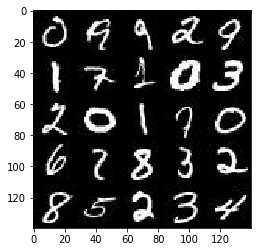

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

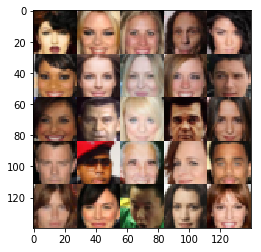

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(dtype=tf.float32, shape=[None, image_width, image_height, image_channels], \
                                 name='real_inputs')
    z_inputs= tf.placeholder(dtype=tf.float32, shape=[None, z_dim], name='z_inputs')
    
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [54]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Define alpha here
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Create the first convolution layer.
        # This will conver input 28x28x? to 14x14x64
        x1 = tf.layers.conv2d(inputs=images, filters=64, kernel_size=[5,5], strides=[2,2], padding='same')
        # Apply only leaky Relu activation to first layer output
        x1 = tf.maximum(x1, x1 * alpha)
        
        # Add second layer of convolution to convert 14x14x64 to 7x7x128
        x2 = tf.layers.conv2d(inputs=x1, filters=128, kernel_size=[5,5], strides=[2,2], padding='same')
        # Add batch normalization layer
        x2 = tf.layers.batch_normalization(inputs=x2, training=True)
        # Add a leaky Relu activation layer
        x2 = tf.maximum(x2, x2 * alpha)
        
        # Add second layer of convolution to convert 7x7128 to 4x4x256
        x3 = tf.layers.conv2d(inputs=x2, filters=256, kernel_size=[5,5], strides=[2,2], padding='same')
        # Add batch normalization layer
        x3 = tf.layers.batch_normalization(inputs=x3, training=True)
        # Add a leaky Relu activation layer
        x3 = tf.maximum(x3, x3 * alpha)
        
        # Flatten the output
        x4 = tf.reshape(tensor=x3, shape=[-1, 4*4*256])
        
        logits = tf.layers.dense(inputs=x4, units=1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [65]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer, map inputs dim to 4*4*512 output
        x1 = tf.layers.dense(inputs=z, units=4*4*512)
        
        # Reshape this input as per our requirement for convolution
        x1 = tf.reshape(tensor=x1, shape=[-1,4,4,512])
        
        # Apply batch normalization
        x1 = tf.layers.batch_normalization(inputs=x1, training=is_train)
        # Apply leaky Relu acitivation
        x1 = tf.maximum(x1, x1 * alpha)
        
        # Reshape it to 7x7x256, tricky part
        # is to change shape from 4x4x512 to 7x7x256
        x2 = tf.layers.conv2d_transpose(inputs=x1, filters=256, kernel_size=[4,4], strides=[1,1], padding='valid')
        # Apply batch normalization
        x2 = tf.layers.batch_normalization(inputs=x2, training=is_train)
        # Apply leaky Relu activation
        x2 = tf.maximum(x2, x2 * alpha)
        #print(x2.shape)
        
        # Reshape it to 14x14x128
        x3 = tf.layers.conv2d_transpose(inputs=x2, filters=128, kernel_size=[5,5], strides=[2,2], padding='same')
        # Apply batch normalization
        x3 = tf.layers.batch_normalization(inputs=x3, training=is_train)
        # Apply leaky Relu activation
        x3 = tf.maximum(x3, x3 * alpha)
        
        
        # Reshape it to 28x28x64
        x4 = tf.layers.conv2d_transpose(inputs=x3, filters=64, kernel_size=[5,5], strides=[2,2], padding='same')
        # Apply batch normalization
        x4 = tf.layers.batch_normalization(inputs=x4, training=is_train)
        # Apply leaky Relu activation
        x4 = tf.maximum(x4, x4 * alpha)
        #print(x4.shape)
        
        # Output layer, 28x28x3
        logits = tf.layers.conv2d_transpose(inputs=x4, filters=out_channel_dim, kernel_size=[5,5], strides=[1,1], \
                                            padding='same')
        
        out = tf.tanh(logits)
        
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [66]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Find the output of generator
    g_model = generator(input_z, out_channel_dim=out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Find out the losses
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [67]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get all the training variables
    t_vars = tf.trainable_variables()
    
    # Get vars for discriminator
    d_vars = [d_var for d_var in t_vars if d_var.name.startswith('discriminator')]
    g_vars = [g_var for g_var in t_vars if g_var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [68]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [74]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_inputs, z_inputs, rate_learning = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_inputs, z_inputs, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, rate_learning, beta1)
    
    sample_z = np.random.uniform(-1, 1, size=(72, 100))
    
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Reshape the images as per need
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, \
                                                    rate_learning: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_inputs: batch_z, real_inputs: batch_images, \
                                                    rate_learning: learning_rate})
                
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_inputs: batch_z, real_inputs: batch_images})
                    train_loss_g = g_loss.eval({z_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    
                if steps % show_every == 0:
                    _ = show_generator_output(sess, 72, z_inputs, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6040... Generator Loss: 2.0725
Epoch 1/2... Discriminator Loss: 0.3257... Generator Loss: 6.7453
Epoch 1/2... Discriminator Loss: 0.4384... Generator Loss: 10.2390
Epoch 1/2... Discriminator Loss: 0.1866... Generator Loss: 2.4925
Epoch 1/2... Discriminator Loss: 0.0896... Generator Loss: 3.2844
Epoch 1/2... Discriminator Loss: 0.6809... Generator Loss: 0.7832
Epoch 1/2... Discriminator Loss: 0.1152... Generator Loss: 3.4286
Epoch 1/2... Discriminator Loss: 0.9551... Generator Loss: 1.7356
Epoch 1/2... Discriminator Loss: 0.1286... Generator Loss: 2.5539
Epoch 1/2... Discriminator Loss: 1.4340... Generator Loss: 0.3513


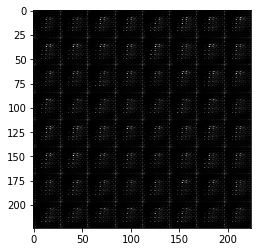

Epoch 1/2... Discriminator Loss: 0.2569... Generator Loss: 3.7355
Epoch 1/2... Discriminator Loss: 0.4031... Generator Loss: 4.9233
Epoch 1/2... Discriminator Loss: 0.4305... Generator Loss: 6.1868
Epoch 1/2... Discriminator Loss: 0.2216... Generator Loss: 2.6103
Epoch 1/2... Discriminator Loss: 0.1126... Generator Loss: 3.1872
Epoch 1/2... Discriminator Loss: 0.1416... Generator Loss: 2.8523
Epoch 1/2... Discriminator Loss: 0.9576... Generator Loss: 0.9173
Epoch 1/2... Discriminator Loss: 0.3605... Generator Loss: 2.4862
Epoch 1/2... Discriminator Loss: 0.3223... Generator Loss: 2.6277
Epoch 1/2... Discriminator Loss: 0.6610... Generator Loss: 2.7725


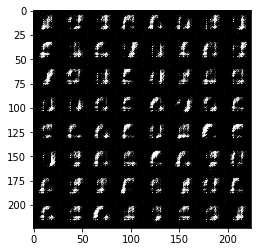

Epoch 1/2... Discriminator Loss: 0.5739... Generator Loss: 1.7307
Epoch 1/2... Discriminator Loss: 0.9852... Generator Loss: 0.6452
Epoch 1/2... Discriminator Loss: 0.3721... Generator Loss: 2.1703
Epoch 1/2... Discriminator Loss: 0.5813... Generator Loss: 1.7785
Epoch 1/2... Discriminator Loss: 1.1088... Generator Loss: 1.6779
Epoch 1/2... Discriminator Loss: 0.6689... Generator Loss: 1.7880
Epoch 1/2... Discriminator Loss: 0.6026... Generator Loss: 1.8147
Epoch 1/2... Discriminator Loss: 0.7510... Generator Loss: 1.7342
Epoch 1/2... Discriminator Loss: 0.5510... Generator Loss: 2.0106
Epoch 1/2... Discriminator Loss: 0.7174... Generator Loss: 1.3908


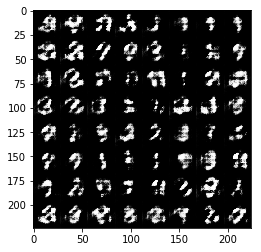

Epoch 1/2... Discriminator Loss: 1.3024... Generator Loss: 3.1472
Epoch 1/2... Discriminator Loss: 0.6793... Generator Loss: 1.4692
Epoch 1/2... Discriminator Loss: 1.2389... Generator Loss: 2.5463
Epoch 1/2... Discriminator Loss: 1.1234... Generator Loss: 0.6877
Epoch 1/2... Discriminator Loss: 0.9990... Generator Loss: 2.1504
Epoch 1/2... Discriminator Loss: 0.9764... Generator Loss: 1.8286
Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 1.0178
Epoch 1/2... Discriminator Loss: 0.8501... Generator Loss: 1.3516
Epoch 1/2... Discriminator Loss: 0.9586... Generator Loss: 2.1860
Epoch 1/2... Discriminator Loss: 0.9326... Generator Loss: 0.9302


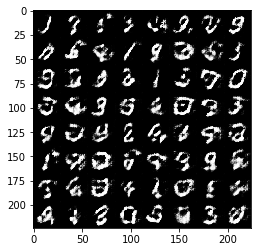

Epoch 1/2... Discriminator Loss: 1.0601... Generator Loss: 0.7982
Epoch 1/2... Discriminator Loss: 0.9278... Generator Loss: 1.4814
Epoch 1/2... Discriminator Loss: 1.0923... Generator Loss: 1.7980
Epoch 1/2... Discriminator Loss: 0.9975... Generator Loss: 1.1240
Epoch 1/2... Discriminator Loss: 1.3832... Generator Loss: 0.5784
Epoch 1/2... Discriminator Loss: 1.0200... Generator Loss: 1.2573
Epoch 2/2... Discriminator Loss: 0.9057... Generator Loss: 1.3448
Epoch 2/2... Discriminator Loss: 0.9885... Generator Loss: 0.9932
Epoch 2/2... Discriminator Loss: 1.2116... Generator Loss: 0.5281
Epoch 2/2... Discriminator Loss: 0.9664... Generator Loss: 0.9405


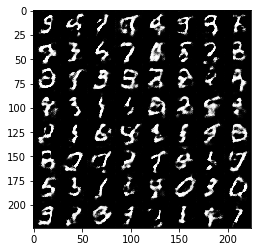

Epoch 2/2... Discriminator Loss: 0.8887... Generator Loss: 1.2322
Epoch 2/2... Discriminator Loss: 0.9946... Generator Loss: 0.7763
Epoch 2/2... Discriminator Loss: 1.0251... Generator Loss: 0.8373
Epoch 2/2... Discriminator Loss: 1.2559... Generator Loss: 2.0274
Epoch 2/2... Discriminator Loss: 0.8775... Generator Loss: 1.0164
Epoch 2/2... Discriminator Loss: 1.0931... Generator Loss: 1.5078
Epoch 2/2... Discriminator Loss: 1.0247... Generator Loss: 0.7406
Epoch 2/2... Discriminator Loss: 0.9949... Generator Loss: 0.8295
Epoch 2/2... Discriminator Loss: 1.0776... Generator Loss: 0.8606
Epoch 2/2... Discriminator Loss: 1.0993... Generator Loss: 0.6367


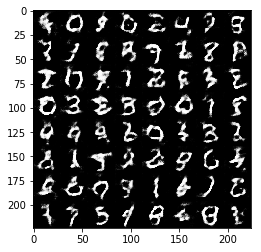

Epoch 2/2... Discriminator Loss: 1.0185... Generator Loss: 1.7386
Epoch 2/2... Discriminator Loss: 1.0643... Generator Loss: 1.5356
Epoch 2/2... Discriminator Loss: 1.1101... Generator Loss: 1.2130
Epoch 2/2... Discriminator Loss: 1.1393... Generator Loss: 1.6390
Epoch 2/2... Discriminator Loss: 0.9224... Generator Loss: 1.1798
Epoch 2/2... Discriminator Loss: 1.1040... Generator Loss: 1.2313
Epoch 2/2... Discriminator Loss: 1.0861... Generator Loss: 1.6345
Epoch 2/2... Discriminator Loss: 0.9806... Generator Loss: 0.8758
Epoch 2/2... Discriminator Loss: 1.1223... Generator Loss: 0.6700
Epoch 2/2... Discriminator Loss: 1.1661... Generator Loss: 1.1589


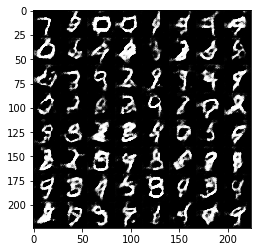

Epoch 2/2... Discriminator Loss: 1.0519... Generator Loss: 1.3183
Epoch 2/2... Discriminator Loss: 1.0528... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.0247... Generator Loss: 1.5580
Epoch 2/2... Discriminator Loss: 1.0981... Generator Loss: 0.6947
Epoch 2/2... Discriminator Loss: 1.0143... Generator Loss: 0.9644
Epoch 2/2... Discriminator Loss: 1.0372... Generator Loss: 0.8475
Epoch 2/2... Discriminator Loss: 1.1861... Generator Loss: 1.5945
Epoch 2/2... Discriminator Loss: 1.0941... Generator Loss: 0.8693
Epoch 2/2... Discriminator Loss: 1.3186... Generator Loss: 0.4521
Epoch 2/2... Discriminator Loss: 1.0864... Generator Loss: 0.7870


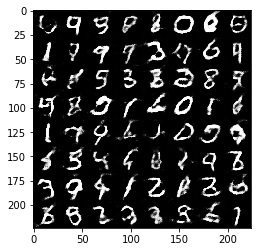

Epoch 2/2... Discriminator Loss: 1.0908... Generator Loss: 1.1799
Epoch 2/2... Discriminator Loss: 1.0320... Generator Loss: 0.8584
Epoch 2/2... Discriminator Loss: 1.0040... Generator Loss: 0.8433
Epoch 2/2... Discriminator Loss: 1.0165... Generator Loss: 1.0978
Epoch 2/2... Discriminator Loss: 0.9613... Generator Loss: 1.0623
Epoch 2/2... Discriminator Loss: 1.2336... Generator Loss: 1.6524
Epoch 2/2... Discriminator Loss: 1.0602... Generator Loss: 0.9419
Epoch 2/2... Discriminator Loss: 1.0301... Generator Loss: 0.8587
Epoch 2/2... Discriminator Loss: 1.0859... Generator Loss: 0.7071
Epoch 2/2... Discriminator Loss: 1.0474... Generator Loss: 0.9792


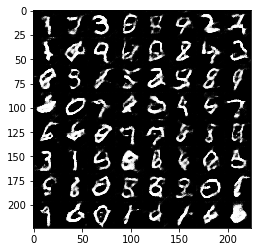

Epoch 2/2... Discriminator Loss: 0.9765... Generator Loss: 0.9915
Epoch 2/2... Discriminator Loss: 1.0303... Generator Loss: 0.7277
Epoch 2/2... Discriminator Loss: 1.0565... Generator Loss: 0.7093


In [75]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.8098... Generator Loss: 0.3110
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 0.1930... Generator Loss: 3.7176
Epoch 1/1... Discriminator Loss: 0.3684... Generator Loss: 3.1541
Epoch 1/1... Discriminator Loss: 0.3215... Generator Loss: 2.5989
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 0.2738... Generator Loss: 2.9911
Epoch 1/1... Discriminator Loss: 0.5087... Generator Loss: 2.8524
Epoch 1/1... Discriminator Loss: 0.2689... Generator Loss: 3.5924
Epoch 1/1... Discriminator Loss: 0.5493... Generator Loss: 1.2938


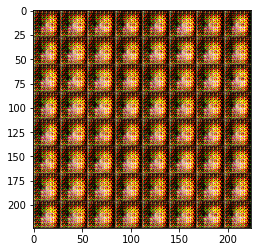

Epoch 1/1... Discriminator Loss: 0.3083... Generator Loss: 1.9883
Epoch 1/1... Discriminator Loss: 0.1922... Generator Loss: 2.7305
Epoch 1/1... Discriminator Loss: 0.2609... Generator Loss: 2.3091
Epoch 1/1... Discriminator Loss: 0.2690... Generator Loss: 2.3237
Epoch 1/1... Discriminator Loss: 0.1826... Generator Loss: 2.6434
Epoch 1/1... Discriminator Loss: 0.1568... Generator Loss: 3.2147
Epoch 1/1... Discriminator Loss: 0.2189... Generator Loss: 2.1242
Epoch 1/1... Discriminator Loss: 0.1487... Generator Loss: 2.7314
Epoch 1/1... Discriminator Loss: 0.2611... Generator Loss: 1.5728
Epoch 1/1... Discriminator Loss: 0.1666... Generator Loss: 2.5162


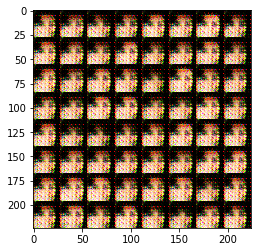

Epoch 1/1... Discriminator Loss: 0.3014... Generator Loss: 2.1852
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.3821
Epoch 1/1... Discriminator Loss: 0.6003... Generator Loss: 2.3240
Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 0.2871... Generator Loss: 5.1666
Epoch 1/1... Discriminator Loss: 0.4884... Generator Loss: 2.7187
Epoch 1/1... Discriminator Loss: 0.6259... Generator Loss: 1.0020
Epoch 1/1... Discriminator Loss: 0.5415... Generator Loss: 1.8038
Epoch 1/1... Discriminator Loss: 0.7885... Generator Loss: 2.1816
Epoch 1/1... Discriminator Loss: 0.5219... Generator Loss: 2.4700


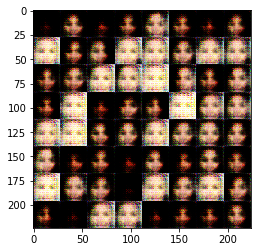

Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 5.3910
Epoch 1/1... Discriminator Loss: 0.4810... Generator Loss: 1.6889
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 0.9706
Epoch 1/1... Discriminator Loss: 0.6088... Generator Loss: 2.2276
Epoch 1/1... Discriminator Loss: 0.5534... Generator Loss: 1.5315
Epoch 1/1... Discriminator Loss: 0.6403... Generator Loss: 1.8237
Epoch 1/1... Discriminator Loss: 0.5654... Generator Loss: 1.6677
Epoch 1/1... Discriminator Loss: 0.6849... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 0.7114... Generator Loss: 1.1464
Epoch 1/1... Discriminator Loss: 0.5945... Generator Loss: 1.4501


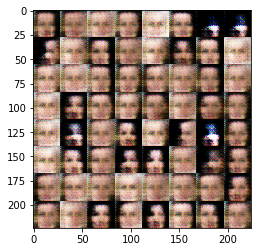

Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 0.6824... Generator Loss: 1.5113
Epoch 1/1... Discriminator Loss: 1.0263... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 1.9356
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 0.9995
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 0.9585
Epoch 1/1... Discriminator Loss: 0.7957... Generator Loss: 1.1852
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 2.8753
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 3.8164


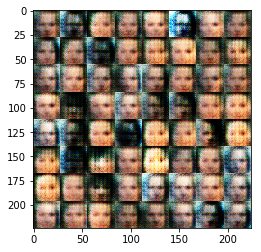

Epoch 1/1... Discriminator Loss: 2.1632... Generator Loss: 3.7846
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 3.4527
Epoch 1/1... Discriminator Loss: 0.3968... Generator Loss: 1.7217
Epoch 1/1... Discriminator Loss: 0.7306... Generator Loss: 1.4947
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 1.7640
Epoch 1/1... Discriminator Loss: 0.6726... Generator Loss: 1.2245
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 4.2561
Epoch 1/1... Discriminator Loss: 0.8654... Generator Loss: 1.0824
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 1.7536
Epoch 1/1... Discriminator Loss: 0.3829... Generator Loss: 1.7518


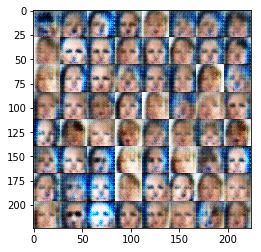

Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 1.1182
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 0.9511
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 1.2171
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 0.8580... Generator Loss: 1.3105
Epoch 1/1... Discriminator Loss: 0.6861... Generator Loss: 1.6568


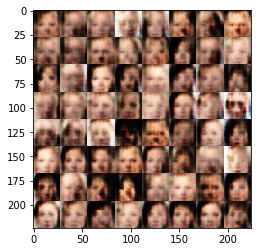

Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 1.3361
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 2.3971
Epoch 1/1... Discriminator Loss: 0.7559... Generator Loss: 1.3881
Epoch 1/1... Discriminator Loss: 0.7437... Generator Loss: 1.2927
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.8158... Generator Loss: 0.2916
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.8347


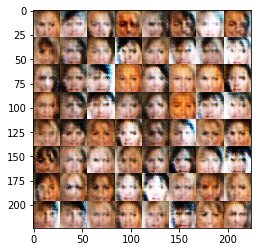

Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 1.5381
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 1.3005
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 1.0153
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 1.2083
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 1.3727
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 1.1448


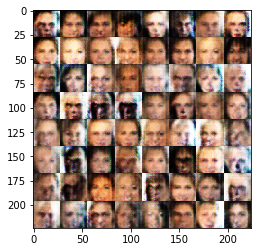

Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 2.1084
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 1.1988
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.7146... Generator Loss: 0.3655
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 0.9303


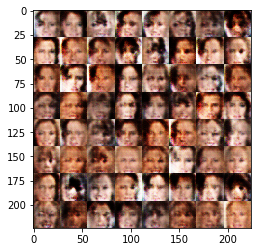

Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 1.5099
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 1.3324
Epoch 1/1... Discriminator Loss: 0.9501... Generator Loss: 1.8072
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 1.1245
Epoch 1/1... Discriminator Loss: 0.8006... Generator Loss: 1.2733
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 1.4689
Epoch 1/1... Discriminator Loss: 1.6888... Generator Loss: 1.9989
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 0.9765


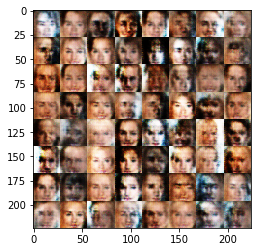

Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 2.0629
Epoch 1/1... Discriminator Loss: 1.6168... Generator Loss: 1.3364
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.4528
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 0.9029... Generator Loss: 1.2701
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 1.3499
Epoch 1/1... Discriminator Loss: 1.7144... Generator Loss: 1.5800


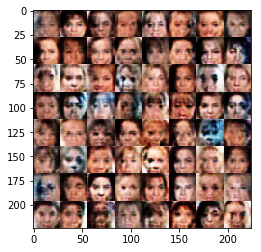

Epoch 1/1... Discriminator Loss: 0.8954... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.5795... Generator Loss: 0.5003
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.3852
Epoch 1/1... Discriminator Loss: 0.8427... Generator Loss: 1.1807
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 2.5024
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 0.7198... Generator Loss: 1.4211
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.4693
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.4382
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 0.8017


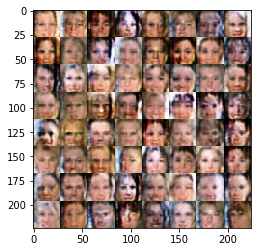

Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.1009
Epoch 1/1... Discriminator Loss: 0.8578... Generator Loss: 1.7841
Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 1.3937
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 1.5220
Epoch 1/1... Discriminator Loss: 0.9278... Generator Loss: 1.1384
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 1.0542


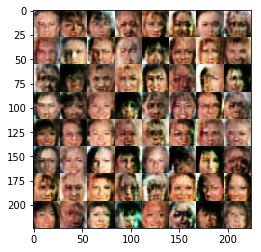

Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 0.9341... Generator Loss: 1.2885
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 0.9795... Generator Loss: 1.6062
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 1.2010
Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 1.3513
Epoch 1/1... Discriminator Loss: 0.9428... Generator Loss: 1.3142
Epoch 1/1... Discriminator Loss: 0.9501... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 0.9057


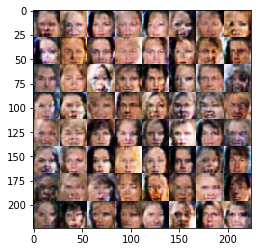

Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 1.1253
Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.8539... Generator Loss: 0.2507
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 0.9121... Generator Loss: 1.0713
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 1.3125
Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 1.0309


In [76]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.